<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_clockRecovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test clock Recovery 

This notebook contains test cases to demonstrate the functionality of clock recovery algorithms in optical communication systems. In the simulations, signals are generated and impaired with clock sampling error. Next, clock recovery algorithms available in OptiCommPy are applied to compensate for the sampling clock mismatch. To verify that each algorithm is working properly, each test case should output clear QAM constellations, without sampling error, and the estimated clock drift should be close to the value inserted in the simulation.

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
from optic.dsp.core import firFilter, pulseShape, pnorm, upsample, clockSamplingInterp
from optic.utils import parameters
from optic.plot import pconst, plotPSD, eyediagram
from optic.comm.modulation import modulateGray
from optic.comm.metrics import fastBERcalc
import matplotlib.pyplot as plt
import numpy as np
from numba import njit

from optic.models.devices import adc
from optic.dsp.clockRecovery import gardnerClockRecovery

import logging as logg
logg.basicConfig(level=logg.INFO, format='%(message)s', force=True)

In [3]:
%load_ext autoreload
%autoreload 2

## Test clock recovery

ADC sampling rate = 64.01280 GS/s
ADC sampling clock drift (ΔFs) = 200.00 ppm


Running clock recovery...
Estimated clock drift mode 0: 200.04 ppm
Estimated clock drift mode 1: 200.69 ppm


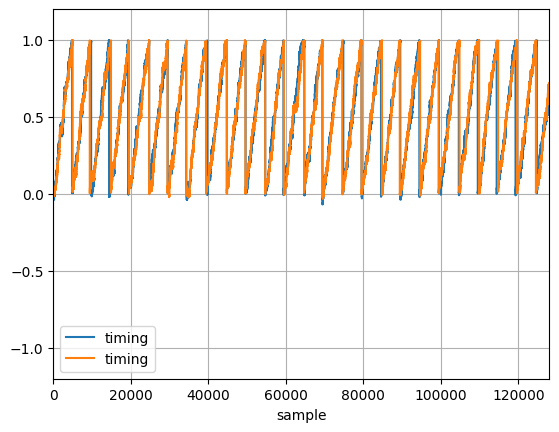

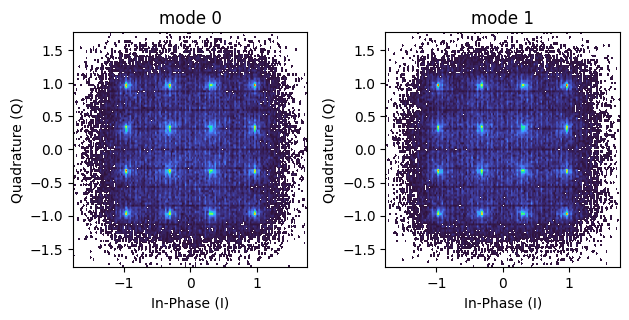

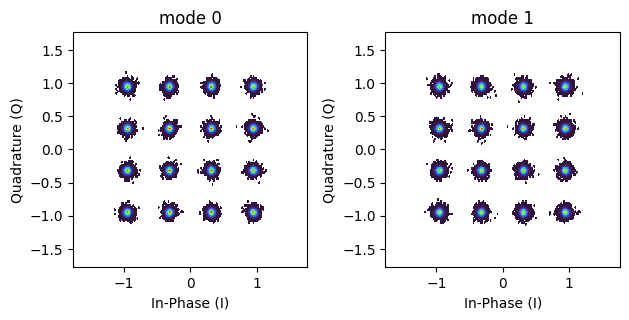

Mode 0: BER = 0.00e+00
Mode 1: BER = 0.00e+00


In [10]:
# simulation parameters
SpS = 16          # samples per symbol
M = 16            # order of the modulation format
Rs = 32e9         # Symbol rate (for OOK case Rs = Rb)
Fs = SpS*Rs       # Sampling frequency in samples/second
Ts = 1/Fs         # Sampling period
ppm = 200        # Deviation of the ADC sampling rate in ppm

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=int(np.log2(M)*128e3))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'qam')    
symbTx = pnorm(symbTx) # power normalization
symbTx = symbTx.reshape(-1,2)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulse shaping
paramPS = parameters()
paramPS.SpS = SpS
paramPS.nFilterTaps = 1024
paramPS.rollOff = 0.1
paramPS.pulseType = 'rc'  # raised cosine pulse
pulse = pulseShape(paramPS)
sigTx = firFilter(pulse, symbolsUp)
sigTx = pnorm(sigTx)  # power normalization

# Calculate ADC sampling rate from clock ppm deviation
Fs_adc = 2*Rs*(1 + ppm/1e6)
ppm_meas = (Fs_adc-2*Rs)/(2*Rs)*1e6
print(f'ADC sampling rate = {Fs_adc/1e9:.5f} GS/s')
print(f'ADC sampling clock drift (ΔFs) = {ppm_meas:.2f} ppm')

# ADC input parameters
paramADC = parameters()
paramADC.Fs_in = Fs
paramADC.Fs_out = Fs_adc
paramADC.jitter_rms = 400e-15
paramADC.nBits =  8
paramADC.Vmax = np.max(sigTx.real)
paramADC.Vmin = np.min(sigTx.real)
paramADC.AAF = True
paramADC.N = 1001

sigRx = adc(sigTx, paramADC)

# clock recovery with Gardner's algorithm
paramCLKREC = parameters()
paramCLKREC.isNyquist = True
paramCLKREC.returnTiming = True
paramCLKREC.ki = 1e-6
paramCLKREC.kp = 5e-3
paramCLKREC.maxPPM = ppm

outCLK, ted_values = gardnerClockRecovery(sigRx, paramCLKREC)

# plot curve of estimated timmig error over time
plt.figure()
plt.plot(ted_values, label = 'timing')
plt.xlabel('sample')
plt.grid()
plt.xlim([0, len(sigRx)])
plt.ylim([-1.2, 1.2])
plt.legend()

# plot received constellations without and with clock recovery
discard = 5000
pconst(sigRx[discard::2], pType='fancy');
pconst(outCLK[discard::2],pType='fancy');

# Check BER
symbRx = outCLK[0::2,:].copy()
BER, _, _ = fastBERcalc(symbRx[discard:-discard,:], symbTx[discard:-discard,:], M, 'qam')

for indMode in range(BER.shape[0]):
    print(f'Mode {indMode}: BER = {BER[indMode]:.2e}')